<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
## openEO Platform DEMO
Land Cover change over an alpine region using Client Side Processing

Import the necessary modules fro openEO Client Side Processing

In [1]:
from openeo.local import LocalConnection
local_conn = LocalConnection("./")

#### Have a look at the collection

We will use a collection from Microsoft Planetary Computer:

**10m Annual Land Use Land Cover (9-class)**

https://planetarycomputer.microsoft.com/dataset/io-lulc-9-class

In [2]:
url      = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/io-lulc-9-class"

spatial_extent = {"west": 12.1783447265625,
                  "south": 46.9061837801476,
                  "east": 13.50151062011719,
                  "north": 47.093500502407764}

iulc_9_class_2017 = local_conn.load_stac(url = url,
                             spatial_extent = spatial_extent,
                             temporal_extent = ["2017-01-01", "2017-01-02"]
                            )

# We need to select this temporal internal (2023-01) to get the 2022 data due to how this particular collection is stored in STAC.
# You can experiment changing temporal_extent and check the outout of iulc_9_class_2022.execute()
iulc_9_class_2022 = local_conn.load_stac(url = url,
                             spatial_extent = spatial_extent,
                             temporal_extent = ["2023-01-01", "2023-01-02"]
                            )

C:\Users\mclaus\Miniconda3\envs\stacenv\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
C:\Users\mclaus\Miniconda3\envs\stacenv\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [3]:
iulc_2017 = iulc_9_class_2017.drop_dimension("time").drop_dimension("band").add_dimension(type="bands",name="bands",label="iulc_2017")
iulc_2022 = iulc_9_class_2022.drop_dimension("time").drop_dimension("band").add_dimension(type="bands",name="bands",label="iulc_2022")
iulc_2017_2022 = iulc_2017.merge_cubes(iulc_2022)

The IULC class for "Snow and Ice" is reflected by the values which are equal to 9.

In [4]:
snow_and_ice = iulc_2017_2022.apply(lambda x: x.eq(9))

Compute the difference between the different snow and ice maps:

In [5]:
def compute_difference(data):
    snow_and_ice_2017 = data.array_element(0)
    snow_and_ice_2022 = data.array_element(1)
    return snow_and_ice_2022 - snow_and_ice_2017
    
snow_and_ice_difference = snow_and_ice.reduce_dimension(reducer=compute_difference,dimension="bands").add_dimension(type="bands",name="bands",label="diff")

Merge all in one datacube and visualiza the final process graph:

In [6]:
snow_and_ice_2017_2022_diff = snow_and_ice.merge_cubes(snow_and_ice_difference)
snow_and_ice_2017_2022_diff

Get the result as an Dask based xArray object:

In [7]:
snow_and_ice_2017_2022_diff_xr = snow_and_ice_2017_2022_diff.execute()
snow_and_ice_2017_2022_diff_xr

C:\Users\mclaus\Miniconda3\envs\stacenv\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
C:\Users\mclaus\Miniconda3\envs\stacenv\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray (bands: 3, y: 2359, x: 10116)>
dask.array<getitem, shape=(3, 2359, 10116), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * x                (x) float64 2.851e+05 2.851e+05 ... 3.863e+05 3.863e+05
  * y                (y) float64 5.219e+06 5.219e+06 ... 5.196e+06 5.196e+06
  * bands            (bands) <U9 'iulc_2017' 'iulc_2022' 'diff'
    id               <U8 '33T-2017'
    io:tile_id       <U3 '33T'
    proj:bbox        object {756097.7729520155, 243907.7729520155, 5320646.33...
    ...               ...
    proj:epsg        int32 32633
    proj:transform   object {0.0, 243907.7729520155, 5320646.335981226, 10.0,...
    start_datetime   <U20 '2017-01-01T00:00:00Z'
    raster:bands     object {'nodata': 0, 'spatial_resolution': 10}
    file:size        int32 165589758
    epsg             int32 32633
Attributes:
    reduced_dimensions_min_values:  {'bands': 'iulc_2017'}

Compute the values from the Dask based xArray objects for visualization:

In [8]:
data_2017 = snow_and_ice_2017_2022_diff_xr.sel(bands="iulc_2017")
data_2022 = snow_and_ice_2017_2022_diff_xr.sel(bands="iulc_2022")
data_diff = snow_and_ice_2017_2022_diff_xr.sel(bands="diff")

iulc_9_class_2017 = data_2017.values
iulc_9_class_2022 = data_2022.values
diff = data_diff.values

Compute some statistics on the data:

In [9]:
import numpy as np

diff = iulc_9_class_2017 - iulc_9_class_2022
print("Glaciers and perpetual snow in 2017: ", np.sum(iulc_9_class_2017))
print("Glaciers and perpetual snow in 2022:  ", np.sum(iulc_9_class_2022))

Glaciers and perpetual snow in 2017:  3474257.0
Glaciers and perpetual snow in 2022:   1760962.0


You could also perform the count operation directly in openEO:

In [10]:
snow_and_ice_2017_2022_diff_sum = snow_and_ice_2017_2022_diff.reduce_spatial(reducer="sum")
print(snow_and_ice_2017_2022_diff_sum.execute().sel(bands="iulc_2017").values)

C:\Users\mclaus\Miniconda3\envs\stacenv\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
C:\Users\mclaus\Miniconda3\envs\stacenv\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


3474257.0


Visualize the Glaciers and perpetual snow map for two different years and the differece:

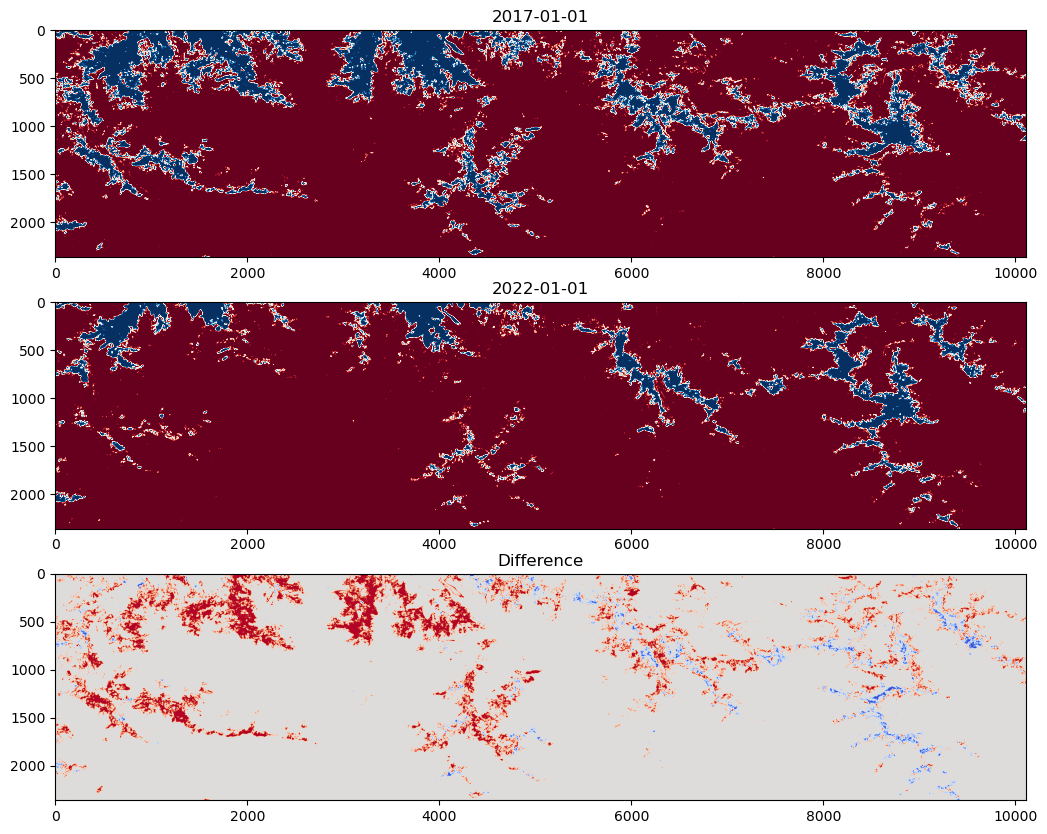

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,10))

plt.subplot(3,1,1)
plt.title("2017-01-01")
plt.imshow(iulc_9_class_2017, cmap = "RdBu")
# plt.colorbar()

plt.subplot(3,1,2)
plt.title("2022-01-01")
plt.imshow(iulc_9_class_2022, cmap = "RdBu")
# plt.colorbar()

plt.subplot(3,1,3)
plt.title("Difference")
plt.imshow(diff, cmap = "coolwarm")
# plt.colorbar()